In [8]:
# My tools: sets the path and adds some math macros for LaTeX equations
# Needs internet access to install.
try:
    pass
    import mmf_setup
    mmf_setup.nbinit()
except ImportError:
    import sys
    !{sys.executable} -m pip install --user --upgrade mmf-setup
    print("Restart your kernel and try again")

<IPython.core.display.Javascript object>

In [9]:
# Initialize plotting:
%matplotlib inline
# Import numpy and matplotlib.  These aliases are quite standard
import numpy as np, matplotlib.pyplot as plt
import scipy.stats
sp = scipy
# Suppress some logging messages in Pillow (Python Imaging Library)
import logging; logging.getLogger('PIL').setLevel(logging.ERROR)  # Suppress PIL messages

# PQ Denoising
$$\newcommand{\vect}[1]{\vec{\boldsymbol{#1}}}
\newcommand{\uvect}[1]{\hat{\boldsymbol{#1}}}
\newcommand{\abs}[1]{\lvert#1\rvert}
\newcommand{\norm}[1]{\lVert#1\rVert}
\newcommand{\I}{\mathrm{i}}
\newcommand{\ket}[1]{\left|#1\right\rangle}
\newcommand{\bra}[1]{\left\langle#1\right|}
\newcommand{\braket}[1]{\langle#1\rangle}
\newcommand{\Braket}[1]{\left\langle#1\right\rangle}
\newcommand{\op}[1]{\boldsymbol{#1}}
\newcommand{\mat}[1]{\underline{\boldsymbol{#1}}}
\newcommand{\d}{\mathrm{d}}
\newcommand{\D}[1]{\mathcal{D}[#1]\;}
\newcommand{\pdiff}[2]{\frac{\partial{#1}}{\partial{#2}}}
\newcommand{\diff}[2]{\frac{\d{#1}}{\d{#2}}}
\newcommand{\ddiff}[2]{\frac{\delta{#1}}{\delta{#2}}}
\newcommand{\floor}[1]{\left\lfloor#1\right\rfloor}
\newcommand{\ceil}[1]{\left\lceil#1\right\rceil}
\DeclareMathOperator{\Tr}{Tr}
\DeclareMathOperator{\erf}{erf}
\DeclareMathOperator{\erfi}{erfi}
\DeclareMathOperator{\sech}{sech}
\DeclareMathOperator{\sinc}{sinc}
\DeclareMathOperator{\sn}{sn}
\DeclareMathOperator{\cn}{cn}
\DeclareMathOperator{\dn}{dn}
\DeclareMathOperator{\sgn}{sgn}
\DeclareMathOperator{\order}{O}
\DeclareMathOperator{\diag}{diag}
\DeclareMathOperator{\span}{span}
\newcommand{\mylabel}[1]{\label{#1}\tag{#1}}
\newcommand{\degree}{\circ}$$

$$
  E[u] = \frac{1}{p}\int \abs{\vect{\nabla}u}^p + \lambda \frac{1}{q}\int\abs{u - d}^q,\\
  E'[u] = -\vect{\nabla}u\cdot( \abs{\vect{\nabla}u}^{p-2}\vect{\nabla}u) + \lambda (u-d)\abs{u - d}^{q-2}.
$$

When $p<2$ or $q<2$, the computation of $E'(u)$ can run into numerical issues (divide by zero).  We can regulate these as follows:

$$
  E'[u] = -\vect{\nabla}u\cdot\Bigl((\vect{\nabla}u)(\abs{\vect{\nabla}u}^2 + \epsilon)^{(p-2)/2}\Bigr) + \lambda (u-d)\Bigl(\abs{u - d} + \eta\Bigr)^{q-2}.
$$

This is what we do in the code, which is slightly different from what was done in class.

Note: $\epsilon$ and $\eta$ (called regulators) added to avoid divide by zero error.

In [39]:
%matplotlib inline
from IPython.display import clear_output
import numpy as np, matplotlib.pyplot as plt
from math_583 import denoise

sigma = 0.4
lam = 0.1
eps = np.finfo(float).eps
eta = np.finfo(float).eps

im = denoise.Image()
d = denoise.Denoise(image=im, sigma=sigma, lam=lam, mode="wrap")

Nx, Ny = im.shape
dx = dy = 1.0
x = (np.arange(Nx) * dx)[:, np.newaxis] #he didn't change these, but he might have meant to 
y = (np.arange(Ny) * dy)[np.newaxis, :]
kx = 2 * np.pi * np.fft.fftfreq(Nx, dx)[:, np.newaxis]
ky = 2 * np.pi * np.fft.fftfreq(Ny, dy)[np.newaxis, :]

fft, ifft = np.fft.fftn, np.fft.ifftn


def gradient(u):
    """Return the gradient of u."""
    ut = fft(u)
    du_dx = ifft(1j * kx * ut).real
    du_dy = ifft(1j * ky * ut).real
    return du_dx, du_dy


def divergence(ux, uy):
    return (ifft(1j * kx * fft(ux) + 1j * ky * fft(uy))).real #alt return (ifft(1j * kx * fft(ux)) + ifft(1j * ky * fft(uy))).real


def E(u, q=2, p=2, d=d.u_noise, lam=lam, eps=eps, eta=eta):
    """Return E.  Note: this is unregulated at q=1"""
    du_dx, du_dy = gradient(u)
    abs_du_p = (du_dx**2 + du_dy**2)**(p / 2)
    return (abs_du_p + lam * abs(u - d)**q).sum() / Nx / Ny


def dE(u, q=2, p=2, d=d.u_noise, lam=lam, eps=eps, eta=eta):
    du_dx, du_dy = gradient(u)
    abs_du_p_m2 = (du_dx**2 + du_dy**2 + eps)**((p - 2) / 2)
    return (-divergence(abs_du_p_m2 * du_dx, abs_du_p_m2 * du_dy) + lam * (u - d) * (abs(u - d) + eta)**(q - 2)) / Nx / Ny #alt eta**2. eps and eta are machine precision terms
            
def pack(u):
    return u.ravel()


def unpack(x):
    return x.reshape((Nx, Ny))


def f(x, **kw):
    u = unpack(x)
    return E(u, **kw)


def df(x, **kw):
    u = unpack(x)
    return pack(dE(u, **kw))


def callback(x, plot=False):
    u = unpack(x)

    msg = f"E={E(u):.4g}"
    if plot:
        import IPython.display

        fig = plt.gcf()
        ax = plt.gca()
        ax.cla()
        IPython.display.clear_output(wait=True)
        im.show(u, ax=ax)
        ax.set(title=msg)
        IPython.display.display(fig)
    else:
        print(msg)

SyntaxError: invalid syntax (1748473246.py, line 48)

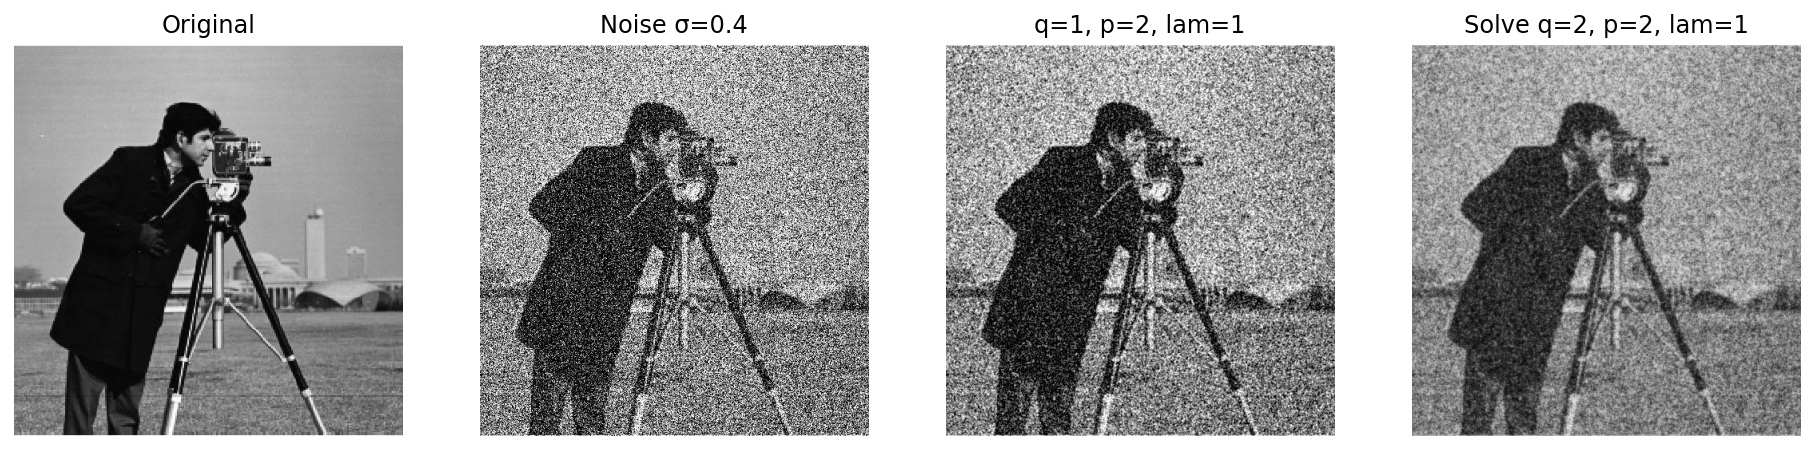

In [21]:
from functools import partial
from scipy.optimize import minimize

eta = eps = np.finfo(float).eps #don't change these for now
sigma = 0.4 #noise weight
lam = 1 #fidelity weight 
q = 1  # Try 1.1
p = 2 # Try 1.1

im = denoise.Image()
d = denoise.Denoise(image=im, sigma=sigma, lam=lam, mode="wrap")

x0 = pack(d.u_noise)

args = dict(p=p, q=q, lam=lam, d=d.u_noise, eps=eps, eta=eta)
res = minimize(partial(f, **args),
               x0=x0,
               jac=partial(df, **args),
               method="L-BFGS-B",
               tol=1e-6, #increase tolerance for fast run speed
               callback=partial(callback, plot=False)) #plot  False for faster
clear_output()
u_solve = d.solve()

data = [
    ("Original", d.u_exact),
    (f"Noise σ={sigma}", d.u_noise),
    (f"{q=}, {p=}, {lam=}", unpack(res.x)),
    (f"Solve q=2, p=2, {lam=}", u_solve),
]

fig, axs = denoise.subplots(len(data), height=4)
for ax, (title, u) in zip(axs, data):
    im.show(u, ax=ax)
    ax.set(title=title)

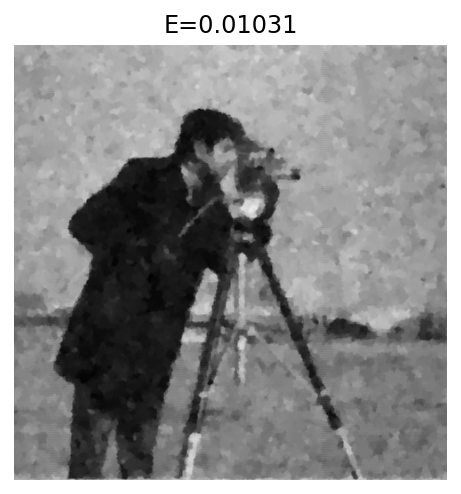

KeyboardInterrupt: 

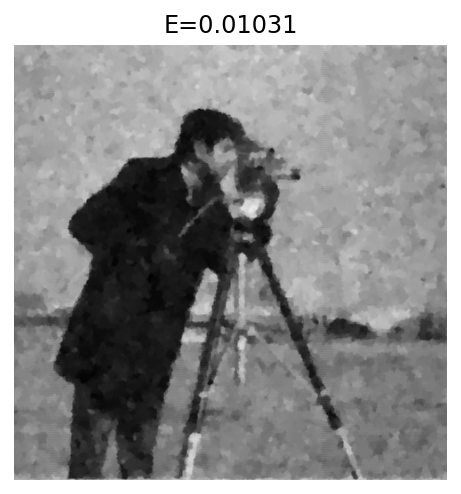

In [34]:
from functools import partial
from scipy.optimize import minimize

eta = eps = np.finfo(float).eps #don't change these for now
sigma = .4 #noise weight
lam = 1 #fidelity weight 
q = 1.1  # Try 1.1
p = 1.1 # Try 1.1

im = denoise.Image()
d = denoise.Denoise(image=im, sigma=sigma, lam=lam, mode="wrap")

x0 = pack(d.u_noise)

args = dict(p=p, q=q, lam=lam, d=d.u_noise, eps=eps, eta=eta)
res = minimize(partial(f, **args),
               x0=x0,
               jac=partial(df, **args),
               method="L-BFGS-B",
               tol=eps, #increase tolerance for fast run speed
               callback=partial(callback, plot=True)) #plot  False for faster got rid of callback.
clear_output()
u_solve = d.solve()

data = [
    ("Original", d.u_exact),
    (f"Noise σ={sigma}", d.u_noise),
    (f"{q=}, {p=}, {lam=}", unpack(res.x)),
    (f"Solve q=2, p=2, {lam=}", u_solve),
]

fig, axs = denoise.subplots(len(data), height=4)
for ax, (title, u) in zip(axs, data):
    im.show(u, ax=ax)
    ax.set(title=title)

## Improvements

The code is quite slow...  One issue might be that $E'(u)$ is not exactly the derivative of $E(u)$ due to violations of the product rule.  Those so inclined might like to try to derive and fix $E(u)$ and $E'(u)$ so that they are numerically exact.

The code above may also perform unecessary calculations.  I have tried to remove the obvious redundancies, but there are probably some better ideas.  For example, one can use the following identity (this is more helpful in 3 dimensions where it can reduce the number of FFT's needed):

$$
  \vect{\nabla}a\cdot\vect{\nabla}b = \frac{\nabla^2(ab) - b\nabla^2a - a\nabla^2b}{2}.
$$

Note that this suffers from the product rule issues, so one must be careful if using this.